In [ ]:
from keras import layers
import pandas as pd
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D,Input, Dense
from keras.models import Model
from matplotlib.pyplot import imshow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
traindf = pd.read_csv("data/training.csv")
testdf =pd.read_csv("data/test.csv")
# print(  type(traindf.iloc[0]['Image']))
# before 'Image' is stored as string, it is converted to matrix
traindf['Image'] = traindf['Image'].apply(lambda im: np.fromstring(im, sep=' '))
testdf['Image'] = testdf['Image'].apply(lambda im: np.fromstring(im, sep=' '))

In [3]:
# examples having missing values
# (4909, 31)
missdf =traindf[traindf.isnull().any(axis=1) ]
missX = np.vstack(missdf['Image'].values)/255
missX = missX.astype(np.float32)
missX = missX.reshape(missX.shape[0], 96,96,1)
missY = missdf.drop('Image', axis=1).values

In [4]:

traindf1 = traindf[traindf.isnull().any(axis=1)!=1 ]
print( type(traindf1.iloc[1]['Image'] ))

X_train = np.vstack(traindf1['Image'].values)/255
X_train = X_train.astype(np.float32)
X_train = X_train.reshape(X_train.shape[0], 96,96,1)

Y_train= traindf1.drop('Image', axis=1).values
Y_train = (Y_train-48)/48
Y_train =Y_train.astype(np.float32)

<class 'numpy.ndarray'>


In [5]:
print(Y_train.shape)
print(X_train.shape)

(2140, 30)
(2140, 96, 96, 1)


In [6]:
def lenetmodel(input_shape):
    X_input = Input(input_shape) # input_shape = (96,96)
    X = X_input
    
    X= Conv2D(6, (5,5), strides=(1,1),padding='same', name='conv1')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Activation('relu')(X)
    
    X= Conv2D(16, (5,5), strides=(1,1), name= 'conv2')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Activation('relu')(X)
    
    X= Conv2D(16, (5,5), strides=(1,1), name= 'conv3')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Activation('relu')(X)    
    
    X= Flatten()(X)
    X = Dense(512 , input_dim=(2304,))(X)
    X = Activation('relu')(X)
    X =  Dense(120, input_dim=(512,))(X)
    X = Activation('relu')(X)
    X = Dense(30, input_dim=(120,))(X)
        
    model = Model(inputs= X_input, outputs= X, name='lenet-5' )
    model.summary()
    return model;

In [7]:
model = lenetmodel((96,96,1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 10, batch_size = 128, shuffle= True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 96, 6)         156       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 6)         24        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 6)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 44, 44, 16)        2416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 16)        64        
__________

In [8]:
print(X_train.shape)
print(missX.shape)
print(Y_train.shape)
print(missY.shape)

(2140, 96, 96, 1)
(4909, 96, 96, 1)
(2140, 30)
(4909, 30)


In [9]:
print(missY[100].shape)

(30,)


In [10]:
model.save('intermediate_model.h5')

In [12]:
model = lenetmodel((96,96,1))
model.load_weights('intermediate_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 96, 6)         156       
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 6)         24        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 6)         0         
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 44, 44, 16)        2416      
_________________________________________________________________
batch_normalization_8 (Batch (None, 44, 44, 16)        64        
__________

In [13]:
output = model.predict(missX, batch_size=128 )
print(output.shape)
missY = missY.astype(np.float32)
missY = (missY-48)/48
for i in range(missX.shape[0]):
    for j in range(30):
        if( pd.isnull(missY[i][j]) ):
            missY[i][j] = output[i][j]                

(4909, 30)


In [14]:
X_train = np.append(X_train, missX , axis=0 )
Y_train = np.append(Y_train, missY , axis=0 )

In [15]:
print(X_train.shape)
print(Y_train.shape)

(7049, 96, 96, 1)
(7049, 30)


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 20, batch_size = 128, shuffle=True, validation_split=0.2)

Train on 5639 samples, validate on 1410 samples
Epoch 1/20
5639/5639 [==============================] - 81s 14ms/step - loss: 0.0159 - acc: 0.4173 - val_loss: 0.0042 - val_acc: 0.5915
Epoch 2/20
5639/5639 [==============================] - 73s 13ms/step - loss: 0.0046 - acc: 0.5214 - val_loss: 0.0037 - val_acc: 0.5858
Epoch 3/20
5639/5639 [==============================] - 77s 14ms/step - loss: 0.0045 - acc: 0.5292 - val_loss: 0.0036 - val_acc: 0.5241
Epoch 4/20
5639/5639 [==============================] - 75s 13ms/step - loss: 0.0044 - acc: 0.5253 - val_loss: 0.0036 - val_acc: 0.5972
Epoch 5/20
5639/5639 [==============================] - 73s 13ms/step - loss: 0.0042 - acc: 0.5481 - val_loss: 0.0036 - val_acc: 0.6007
Epoch 6/20
5639/5639 [==============================] - 73s 13ms/step - loss: 0.0041 - acc: 0.5496 - val_loss: 0.0042 - val_acc: 0.5745
Epoch 7/20
5639/5639 [==============================] - 76s 13ms/step - loss: 0.0041 - acc: 0.5483 - val_loss: 0.0037 - val_acc: 0.5745


In [18]:
model.save('my_model_final.h5')

In [ ]:
model = lenetmodel((96,96,1))
model.load_weights('my_model_final.h5')

5109
6349
919
543
3201
4985


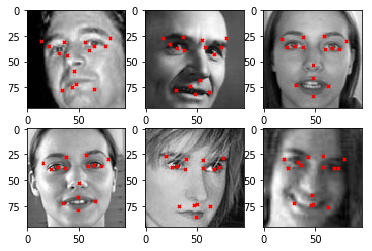

In [20]:
np.random.seed(19680801)
for i in range(6):       
    k = random.randint(0, X_train.shape[0]-1)
    print(k)
    image = np.round(X_train[k] * 255)
    plt.subplot(2,3,i+1)
    plt.imshow(image.reshape(96,96), cmap ='gray' )
    plt.scatter( Y_train[k][0::2] * 48 + 48, Y_train[k][1::2] * 48 + 48, marker='x', s=10, color = 'red')
plt.show()